In [1]:
import matplotlib.pyplot as plt
import numpy as np

This function makes nice $\LaTeX$ labels for different final states

In [2]:
def get_tex_label(fs):
    tex_label = r"$"+ fs
    tex_label = tex_label.replace("pi0", "\pi^0")
    tex_label = tex_label.replace("pi pi", "\pi^+ \pi^-")
    tex_label = tex_label.replace("mu mu", "\mu^+ \mu^-")
    tex_label = tex_label.replace("g", "\gamma")
    tex_label = tex_label.replace("e e", "e^+ e^-")
    return tex_label + r"$"

def get_color(fs):
#     fss = sorted(list(set(ScalarMediator.list_final_states() + VectorMediator.list_final_states())))
    fss = ["pi0 pi pi", "pi0 pi0 pi0", "mu mu", "e e", "g g", "p p"]
    return list(plt.rcParams["axes.prop_cycle"])[fss.index(fs)]["color"]

In [3]:
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import energy_res_comptel, energy_res_fermi
from hazma.gamma_ray_limits.compute_limits import get_detected_spectrum

In [8]:
from hazma.pseudo_scalar_mediator import PseudoScalarMFV

In [9]:
psm = PseudoScalarMFV(mx=200., mp=1e3, gpxx=1., gpqq=1., gpll=0., gpGG=3., gpFF=2./3.)

vx_mw = 1.0e-3  # approximate Milky Way velocity dispersion

Choose arrays of photon energies and DM masses. The DM mass array has the same shape as the array of subplots we want to generate.

In [12]:
e_gam_min, e_gam_max, n_e_gams = 5., 300., 250
e_gams = np.logspace(np.log10(e_gam_min), np.log10(e_gam_max), n_e_gams)

n_subplot_rows, n_subplot_cols = 1, 2
mxs = np.array([200., 220.]).reshape((n_subplot_rows, n_subplot_cols))

Iterate over the array of dark matter masses, computing the spectrum at each $E_\gamma \in$ `e_gams`. Most of the code below formats the plot nicely; the `spectra()` function is called in line 12.

/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationW

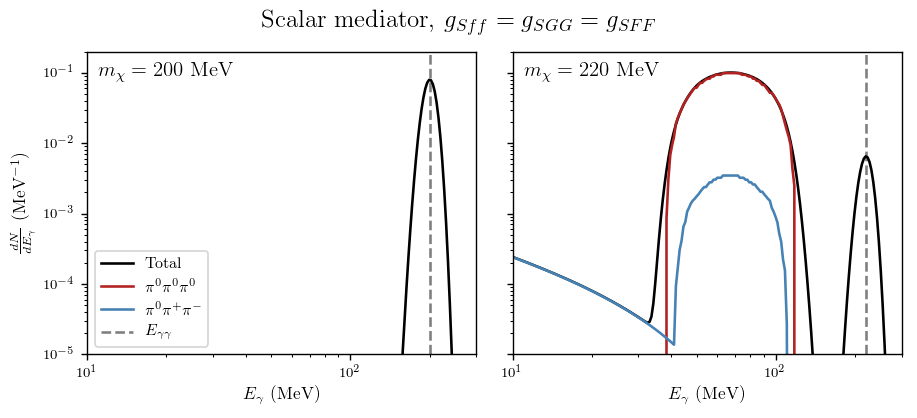

In [21]:
plt.figure(figsize=(7.5, 3.5))

# Iterate over the values, row and column indices of mxs
it = np.nditer(mxs, flags=['multi_index'])

while not it.finished:
    psm.mx = it[0]  # current value of mx
    idx = it.iterindex  # current index in mxs
    row_idx, col_idx = it.multi_index  # current row and column indices
    plt.subplot(n_subplot_rows, n_subplot_cols, idx + 1)
    
    # Center of mass energy, set to slightly above threshold
    e_cm = 2.*psm.mx * (1. + 0.5 * vx_mw)

    # Plot total convolved spectrum
    dnde_det = get_detected_spectrum(lambda es, e_cm: psm.spectra(es, e_cm)["total"],
                                     psm.gamma_ray_lines,
                                     e_gam_min, e_gam_max,
                                     e_cm,
                                     energy_res=energy_res_comptel)
    plt.loglog(e_gams, dnde_det(e_gams), "black", label="Total")
    
    # Plot individual channels' spectra
    for fs, spec in reversed(sorted(psm.spectra(e_gams, e_cm).iteritems())):
        if fs not in ["total", "p p", "e e", "mu mu", "g g"]:
            plt.loglog(e_gams, spec, label=get_tex_label(fs),
                       color=get_color(fs),
                       linewidth=1.5)

    # Mark the lines' energies
    for ch, line in psm.gamma_ray_lines(e_cm).iteritems():
        plt.axvline(line["energy"], linestyle='--', color="k", alpha=0.5, linewidth=1.5, label=r"$E_{\gamma\gamma}$")

    ### Formatting
    # Set axis limits
    plt.xlim(10, 300)
    plt.ylim(1e-5, 2e-1)
        
    # Only draw the legend for the first subplot
    if idx == 0:
        plt.legend(loc="lower left")
        
    # Only show ticks and axis labels for subplots on the left and bottom
    if row_idx != n_subplot_rows - 1:
        plt.tick_params(labelbottom="off")
    else:
        plt.xlabel(r"$E_\gamma$ (MeV)")
    if col_idx % n_subplot_cols != 0:
        plt.tick_params(labelleft="off")
    else:
        plt.ylabel(r"$\frac{dN}{dE_\gamma}$ (MeV$^{-1}$)")
        
    # Label subplot with dark matter mass
    plt.text(1.1e1, 8e-2, r"$m_\chi = %0.f$ MeV" % psm.mx)
    
    it.iternext()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # remove some of the space between plots
plt.suptitle(r"Scalar mediator, $g_{Sff} = g_{SGG} = g_{SFF}$")

plt.savefig("figures/pseudoscalar_spectra_mfv.pdf")